In [1]:
from xai import *
import matplotlib.pyplot as plt
import random
import numpy as np
import torch

In [2]:
latent_dim = 8

try:
    mnist = MNIST.load("mnist.model")
except FileNotFoundError:
    mnist = MNIST(
        latent_shape=(latent_dim,), 
        hidden_layers=2, 
        classifier_head_output_activation="Softmax",
        ) 
    
    mnist.fit_autoencoder(
        epochs=10_000,
        batch_size=256,
        loss_criterion="MSELoss",
        early_stop_cont=750,
        verbose=True,
        info="Mnist autoencoder train"
    )

    mnist.fit_classifier_head(
        epochs=10_000,
        batch_size=256,
        early_stop_cont=750,
        verbose=True,
        info="Mnist classifier-head train"
    )

    mnist.save("mnist.model")
    

In [3]:
mnist.autoencoder.train_stats(info="Mnist autoencoder train").plot_loss()

In [4]:
mnist.classifier_head.train_stats(info="Mnist classifier-head train").plot_loss()

0


CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)


1


KeyboardInterrupt: 

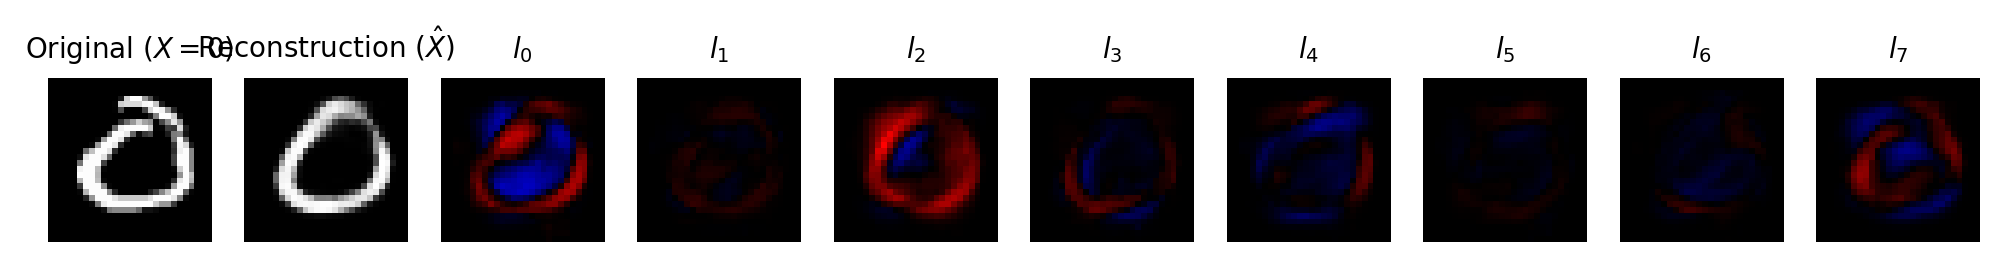

In [3]:
fig = plt.figure(figsize=(12,15), dpi=250) 
rows = 10
columns = latent_dim + 4

#explainer = mnist.autoencoder.decoder.explainer("exact", mnist(mnist.val_data).output())

for row in range(rows):
    print(row)
    slot = row*columns

    sample,label = mnist.get_sample(digit=row)
    sample = sample.numpy(force=True)
    label = int(label.item())
    predict = mnist(sample)
    recon = predict.reconstruction().numpy(force=True)
    digit = predict.digits()[0]
    probabilities = predict.classification().tolist()

    recon_shap = predict.reconstruction.explain("permutation", mnist(mnist.val_data).embedding()).invert().shap_values
    norm = max([np.max(np.abs(recon_shap))])


    fig.add_subplot(rows,columns,slot+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title(f"Original ($X={{{label}}}$)", size=8)
        
    fig.add_subplot(rows,columns,slot+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction ($\hat{{X}}$)", size=8)

    for j,shap in enumerate(recon_shap):
        fig.add_subplot(rows,columns,slot+j+3)
        im = np.zeros((28,28,3), dtype=np.float32)
        red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
        blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
        im[:,:,0] = red
        im[:,:,2] = blue
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"$l_{{{j}}}$", size=8)


fig.tight_layout()
fig.show()

In [4]:
samples = []

for i in range(rows):
    samples.append(mnist.get_sample(digit=i))

unrecognized nn.Module: Reshape
FigureCanvasAgg is non-interactive, and thus cannot be shown


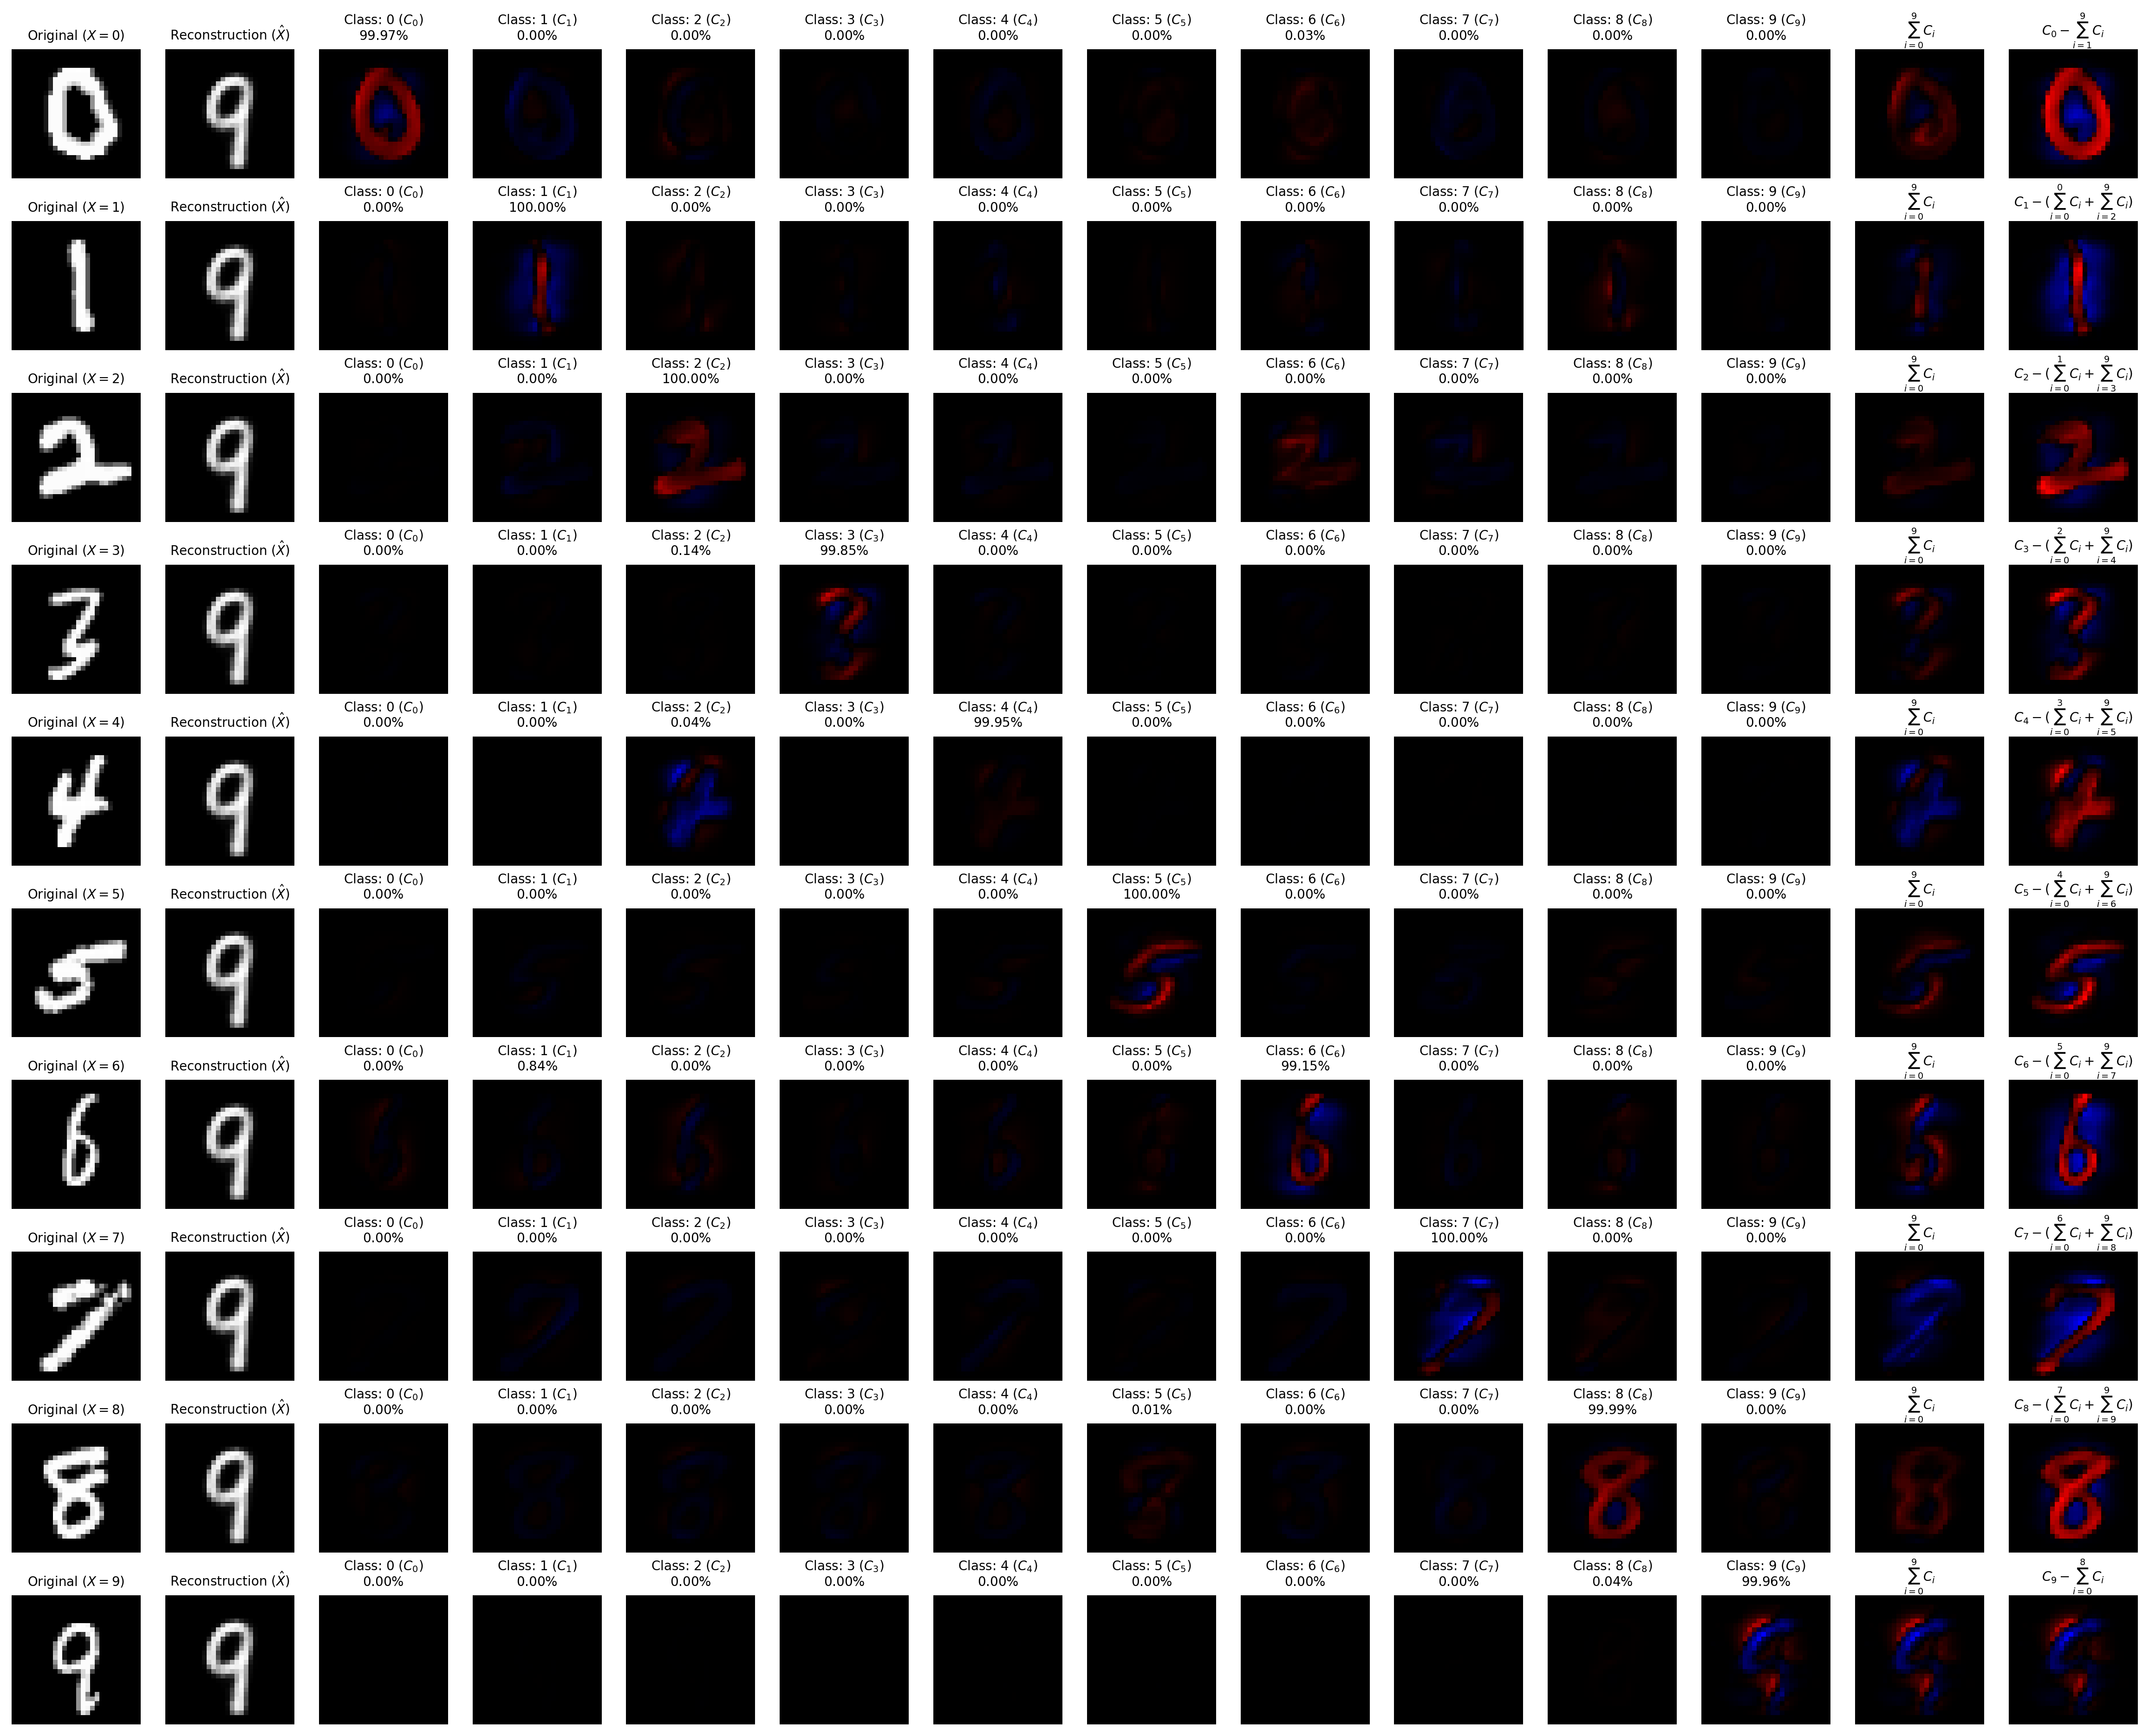

In [10]:
algorithm: Explainers = "deep"
fig = plt.figure(figsize=(20,15), dpi=250) 
rows = 10
columns = 15

for row in range(rows):
    slot = row*columns

    sample,label = sample,label = samples[row]
    sample = sample.numpy(force=True)
    label = int(label.item())
    predict = mnist(sample)
    probabilities = predict.classification().tolist()

    fig.add_subplot(rows,columns,slot+1)
    plt.imshow(sample, cmap="gray")
    plt.axis('off')
    plt.title(f"Original ($X={{{label}}}$)", size=8)
        
    fig.add_subplot(rows,columns,slot+2)
    plt.imshow(recon, cmap="gray")
    plt.axis('off')
    plt.title("Reconstruction ($\hat{{X}}$)", size=8)

    recon_shap = predict.reconstruction.explain(algorithm, mnist(mnist.val_data).embedding())
    cls_shap = predict.classification.explain(algorithm, mnist(mnist.val_data).embedding())

    combined_shap = cls_shap.combine(recon_shap).shap_values
    
    delta_shap: np.ndarray = combined_shap[label] - (combined_shap[:label].sum(axis=0) + combined_shap[label+1:].sum(axis=0))
    shap_sum = combined_shap.sum(axis=0)
    norm = max([np.max(np.abs(combined_shap)), np.max(np.abs(delta_shap)), np.max(np.abs(shap_sum))])

    for j,shap in enumerate(combined_shap):
        fig.add_subplot(rows,columns,slot+j+3)
        im = np.zeros((28,28,3), dtype=np.float32)
        red = np.where(shap > 0, shap/norm, np.zeros_like(shap))
        blue = np.where(shap < 0, -shap/norm, np.zeros_like(shap))
        im[:,:,0] = red
        im[:,:,2] = blue
        plt.imshow(im)
        plt.axis('off')
        plt.title(f"Class: {j} ($C_{j}$)\n${probabilities[j]*100:.2f}$%", size=8)

    
    fig.add_subplot(rows,columns,slot+j+4)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(shap_sum > 0, shap_sum/norm, np.zeros_like(shap_sum))
    blue = np.where(shap_sum < 0, -shap_sum/norm, np.zeros_like(shap_sum))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"$\sum_{{i={0}}}^{{{rows-1}}}{{C_i}}$", size=8)

    fig.add_subplot(rows,columns,slot+j+5)
    im = np.zeros((28,28,3), dtype=np.float32)
    red = np.where(delta_shap > 0, delta_shap/norm, np.zeros_like(delta_shap))
    blue = np.where(delta_shap < 0, -delta_shap/norm, np.zeros_like(delta_shap))
    im[:,:,0] = red
    im[:,:,2] = blue
    plt.imshow(im)
    plt.axis('off')
    if row == 0:
        plt.title(f"$C_{{{label}}} - \sum_{{i={1}}}^{{{rows-1}}}{{C_i}}$", size=8)
    elif row == (rows - 1):
        plt.title(f"$C_{{{label}}} - \sum_{{i={0}}}^{{{rows-2}}}{{C_i}}$", size=8)
    else:
        plt.title(f"$C_{{{label}}} - (\sum_{{i={0}}}^{{{label-1}}}{{C_i}} + \sum_{{i={label+1}}}^{{{rows-1}}}{{C_i}})$", size=8)

fig.tight_layout()
fig.show()